# Uber Marketplace City X Challenge

## Marketplace Data Analyst Recruitment exercise


__David Steele__ <br> __October 23, 2018__

### Goal of the Analysis

City X GM reports inconsistent trip growth in the month of April and believes driver positioning may be non-optimal to handle rush-hour demands. 

Investigate whether notifying drivers of the city's demand in certain geographic areas at certain times could help improve trip growth. Present a strategy to address the challenge.
</ol>

### Deliverables

<ol>
<li>An educated, data-driven view on the potential issue
<li>A A/B test design to evalue a hypothesis or test a solution
<li>Recommended next steps and other factors to consider
</ol>

### Evaluation criteria

<ul>
<li>data cleaning, aggregation, and analysis
<li>identification of key patterns and trends
<li>strong and relevant experiment design
<li>recommendations including actionable next steps
<li>acknowledgement of other factors or considerations
</ul>

In [1]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='solarizedd')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

In [2]:
print(f"This notebook was prepared with:\n  pandas version 0.23.4. Your version: {pd.__version__}")

This notebook was prepared with:
  pandas version 0.23.4. Your version: 0.23.4


## City Demand and Driver Positioning

The city GM believes there are disproportionate levels of surge pricing and higher ETAs in CC - sometimes 1-2 minutes higher than the city average - during rush hour. Also notes trip growth has been inconsistent in April and May. Question: could "fixing" driver placement during CC rush hour help improve rider growth?

Some possible indicators of non-optimal driver positioning could include:
<ul>
<li>surge multiplier disparity: key indicator of poor driver positioning. If surge is 1 or low in one geo and very high in another, drivers could be more optimally positioned. 
<li>fraction of rider cancellations: how does cancellation rate depend on wait time? What is the impact of cancelation on rider retention?
<li>high estimated_times_to_arrival: could indicate poor positioning, but also could be caused by traffic congestion, or lack of driver supply. We can get an idea of the effect of traffic congestion by looking at the number of trips completed per supply hour vs. time of day. 
<li>fraction of trip requests unfulfilled: indicates lack of overall supply. Here, again, looking for disparities between regions would be more indicative of poor positioning, but statistics for unfulfilled trips could be limited
</ul>

## Analysis Approach

<ul>
<li>Quantify the rate of trip growth week over week and search for clues that help understand any trends found
<li>Get an idea of the overall balance between supply and demand across City X, then compare with Chelsea Court and the other three Geos for which data are provided. 
<li>Characterize trends in arrival times and surge pricing for rush-hour vs. non-rush-hour broken down by Geo 
<li>Compare rider cancelation, unfulfilled and failed trip rates during rush-hour vs. non-rush-hour broken down by Geo
<li>Look for clues that indicate the reasons why riders cancel: did they eventually successfully book a trip right after canceling, or does canceling have a negative impact on rider engagement?
<li>If any given geo is experiencing higher wait times or surge pricing, try find the root cause: is demand or could it relate to traffic congestion?
</ul>

<b>NOTE:</b> The Analysis is not necessarily presented in an order that best tells the story that was eventually found. Refer to the slide presentation for that. 

## Summary of Data Cleaning Findings

<ul>
<li>Trip ID 94a1-82d8 is not unique: there four trips with this trip_id. Since four trips will not affect our conclusions these rows were simply dropped 
<li>There is a rider with $139k in lifetime payments and over 16k lifetime trips. This doesn't seem like it could be real. It may be a conglomeration of multiple riders. 
<li>There is a similar situation in the driver data: one driver has an unrealistic number of trips and payouts (see the "Super Driver" section below). All of the driver trips corresponding to theis driver_id have no estimated or actual time to arrival data. 
<li>In addition, so other trips are missing the actual time to arrival, or both the estimated and actual time to arrival data.  For the non super-driver cases, trips that have an estimated time to arrival but no actual time to arrival and a trip status of "rider_canceled" are assumed to have been canceled while the driver was en-route to the pick-up location. For non super-drivers, trips missing both estimated and actual time to arrival and a trip_status of "rider_canceled" were assumed to have been canceled before a driver accepted the trip.
<li>The data set appears to be simulated. The clues are that there almost precisely 60,000 trips and almost exactly 20,000 drivers participating 
</ul>

## Exploring the city info table

In [3]:
city = pd.read_html("city_metrics.html", header=1, index_col='timestamp')[0]

In [4]:
city['datetime'] = pd.to_datetime(city.index)
city.set_index('datetime', drop=True, inplace=True)
city = city.rename(columns={ 'mean_surge_multipler' : 'mean_surge_multiplier' })
city['date'] = city.index.date
city['dow'] = city.index.day_name()
city['woy'] = city.index.weekofyear
city['hour'] = city.index.hour

In [5]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' ]
rush_hours = [ 7, 8, 17, 18 ] 

### Trip Growth (City-wide)

In [6]:
weekly_trips = city.groupby('woy').agg({'trips':['sum']})
n_0 = weekly_trips.iloc[0,:].values[0]
#weekly_trips['growth [%]'] = weekly_trips.apply(lambda x : round(100*(x-n_0)/n_0, 1))
weekly_trips['Week-over-week change [%]'] = round(100*weekly_trips['trips'].diff(1)/weekly_trips['trips'], 1).fillna("")
weekly_trips

,trips,Week-over-week change [%]
,sum,
woy,,
15,16673,
16,15503,-7.5
17,16490,6
18,17270,4.5


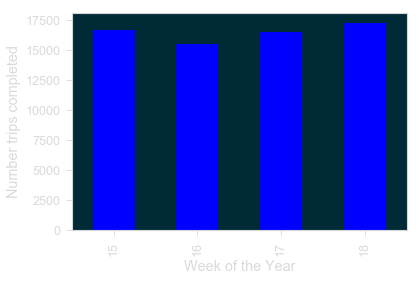

In [7]:
pl = city.groupby('woy').agg('sum').plot(y='trips', kind='bar', color='blue', legend=False)
plt.xlabel("Week of the Year")
plt.ylabel("Number trips completed")

In [8]:
# Trips per supply hour: average number of driver trips/hour 
city['trips_per_supply_hour'] = city['trips']/city['supply_hours']
mean_city_trips_per_supply_hour = city['trips'].sum()/city['supply_hours'].sum()

trips_over_supply = 0
for row in city.itertuples():
    if row.supply_hours > 0:
        trips_over_supply += row.trips*row.trips/row.supply_hours
mean_city_trips_per_driver_hour = trips_over_supply/city['trips'].sum()   
print("    City-wide:")
print(f"     Averaged by trip, the mean number of driver trips per supply hour is {round(mean_city_trips_per_driver_hour,1)}")
print(f"     The total number of trips over the total supply hours is {round(mean_city_trips_per_supply_hour,1)}")
print(f"     The mean trips/supply hour averaged by hour throughout the day is: {round(city.trips_per_supply_hour.mean(),1)}") 

    City-wide:
     Averaged by trip, the mean number of driver trips per supply hour is 2.1
     The total number of trips over the total supply hours is 2.0
     The mean trips/supply hour averaged by hour throughout the day is: 1.9


The distinctions between the three methods of calculating an average number of trips per supply hour is subtle, but understanding the differences provides clues about the balance between of driver supply vs. rider demand throughout the day. 

If the ratio of supply to demand were always the same, each of the metrics should come out equal to the middle one: $ \frac{\text{total trips}}{\text{total supply hours}} $. 

The first average average being slightly higher than the middle one indicates that when rider demand is high, supply is lagging. 

The third average reflects the overall picture of supply vs. demand across all hours of the day. It being lower than the middle average indicates that there is some room for optimizing the timing of supply deployment, reducing supply during off-peak hours and redeploying during peak hours. 

However, all three being so close to the same value as they are suggests that supply deployment is already close to optimum. 

In [9]:
city['trips'].sum()

65936

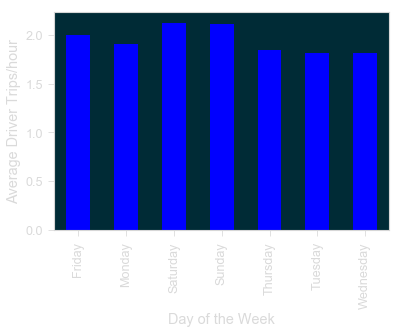

In [10]:

city['trips_per_supply_hour'] = city['trips']/city['supply_hours']
ax = city.groupby('dow').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.ylabel('Average Driver Trips/hour')
l = plt.xlabel('Day of the Week')

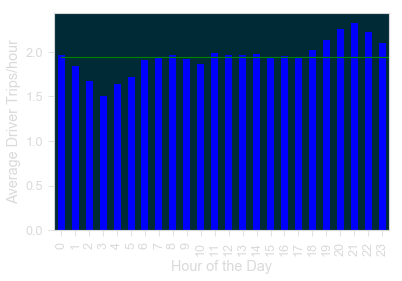

In [11]:
city.groupby('hour').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.plot( [0,24], [city['trips_per_supply_hour'].mean(), city['trips_per_supply_hour'].mean()], color='green')
plt.ylabel('Average Driver Trips/hour')
plt.xlabel('Hour of the Day')

In [12]:
# Trip Supply Deficit: Difference between trips completed and requests. Technically this
# would also include unfulfilled and failed trips, but these are much less common than 
# rider cancelations, so we'll just lump them together
city['rider_cancelations_frac'] = (city['requests'] - city['trips'])/city['requests'] 
city['rider_cancelations'] = city['requests'] - city['trips']

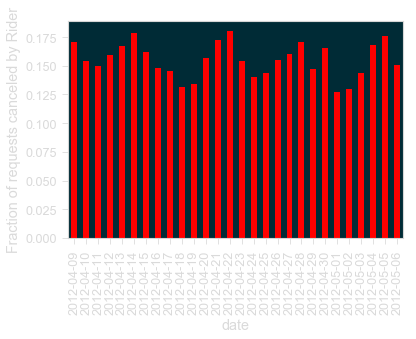

In [13]:
f = city.groupby('date').agg('mean').plot(y='rider_cancelations_frac', kind='bar', color='red', legend=False)
plt.ylabel("Fraction of requests canceled by Rider")

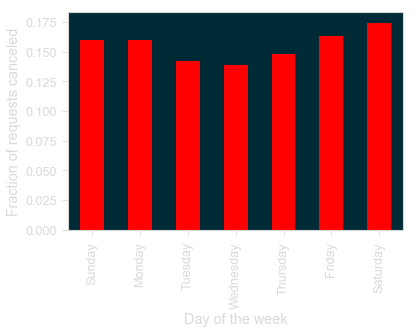

In [14]:
trip_deficit_frac_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations_frac', kind='bar', color='red',  legend=False)
plt.ylabel("Fraction of requests canceled")
plt.xlabel("Day of the week")

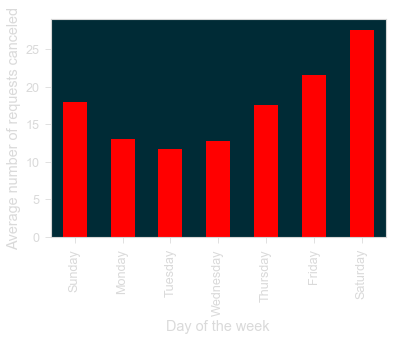

In [15]:
rider_cancelations_number_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations', kind='bar', color='red',  legend=False)
plt.ylabel("Average number of requests canceled")
plt.xlabel("Day of the week")

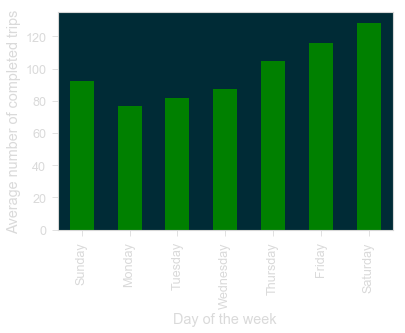

In [16]:
completed_trips_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='trips', kind='bar', color='green',  legend=False)
plt.ylabel("Average number of completed trips")
plt.xlabel("Day of the week")

In [17]:
city_weekdays = city.loc[ city['dow'].isin( weekdays ) ]
weekday_by_hour = city_weekdays.groupby('hour').mean()

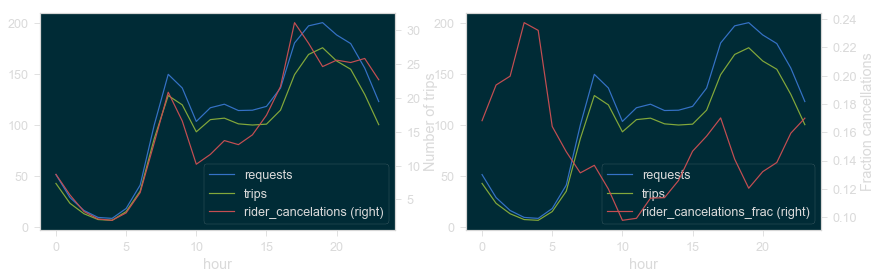

In [18]:
f = plt.figure(figsize=(14,4))
f1 = plt.subplot(121)
weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations'], secondary_y=['rider_cancelations'], ax=f1)
plt.ylabel("Number of trips")
f2 = plt.subplot(122)
weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations_frac'], secondary_y=['rider_cancelations_frac'], ax=f2)
l = plt.ylabel('Fraction cancellations')


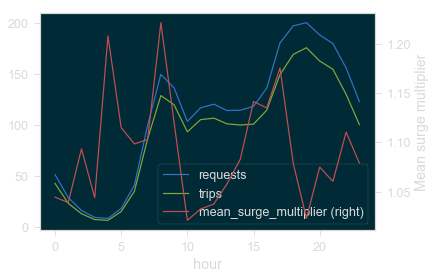

In [19]:
weekday_by_hour.plot(y=['requests', 'trips', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])
l = plt.ylabel("Mean surge multiplier")
l2 = plt.xlabel("Weekday hour of day")

The definition of "rush hour" is somewhat subjective, but we will assume that it includes mornings 8-9 and evenings: 17-20

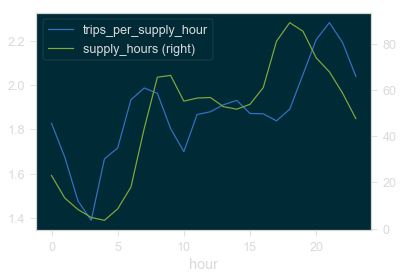

In [20]:
weekday_by_hour.plot(y=['trips_per_supply_hour', 'supply_hours'], secondary_y=['supply_hours'])

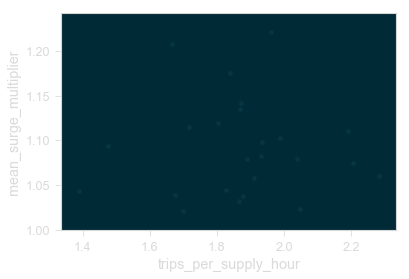

In [21]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter')

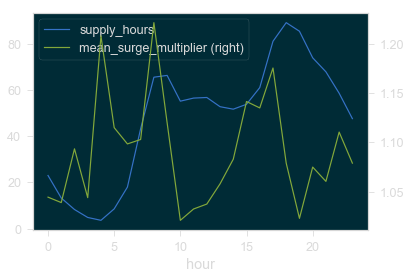

In [22]:
weekday_by_hour.plot(y=['supply_hours', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])

## Trips Data import, cleaning, and aggregation

In [23]:
d_trips = pd.read_html("driver_trips.html", header=1, index_col='trip_id')[0] 

In [24]:
r_trips = pd.read_html("rider_trips.html", header=1, index_col='trip_id')[0]

In [25]:
drivers = pd.read_html("driver_data.html", header=1, index_col='driver_id')[0]
riders = pd.read_html("rider_data.html", header=1, index_col='rider_id')[0]

In [26]:
d_trips.drop(columns="1", inplace=True)
r_trips.drop(columns="1", inplace=True)
drivers.drop(columns="1", inplace=True)
riders.drop(columns="1", inplace=True)

In [27]:
# Join the driver trips and rider trips tables on trip_id
trips = r_trips.join(d_trips, how='left', lsuffix='_d', rsuffix='_r')

In [28]:
dup_columns = [ c_name.replace("_r", "") for c_name in trips.columns if "_r" in c_name ]
for c in dup_columns:
    r_col = c + "_r"
    d_col = c + "_d"
    trips[c] = trips[r_col].where( ~trips[r_col].isnull(), trips[d_col] )
    trips = trips.drop(columns=[r_col, d_col])

In [29]:
# Trip ID 94a1-82d8 is not unique: there four trips with this trip_id. 
# Since four trips will not affect our conclusions, these rows are simply dropped 
trips = trips.drop('94a1-82d8', axis=0)

In [30]:
# We need to copy the trip_id out of the index or else 
# we'll lose it when we groupby
trips['trip_id'] = trips.index.values

In [31]:
trips['request_time'] = pd.to_datetime(trips.request_time)
trips['date'] = trips.request_time.dt.date
trips['dow'] = trips.request_time.dt.day_name()
trips['woy'] = trips.request_time.dt.weekofyear
trips['hour'] = trips.request_time.dt.hour

In [32]:
trips['estimated_less_actual'] = trips['estimated_time_to_arrival'] - trips['actual_time_to_arrival']

In [33]:
trips['is_rush_hour'] = ( trips.hour.isin(rush_hours)) & ( trips.dow.isin(weekdays) )
trips['completed'] = trips.trip_status.apply(lambda x : 1 if x == 'completed' else 0)
# We're ignoring failed and other trip_status values, but we know those occur infrequently
trips['canceled'] = trips.trip_status.apply(lambda x : 1 if x == 'rider_canceled' else 0)
trips['requests'] = trips['completed'] + trips['canceled']

In [34]:
len(trips['rider_id'].unique())

50834

## Trip analysis by Time of Day and Geographic Region

In [35]:
weekday_trips_geo = trips.loc[trips['dow'].isin(weekdays)].groupby([
    'start_geo', 
    'hour']).agg({'completed':'sum', 'canceled':'sum', 'requests':'sum', 'surge_multiplier':'mean', 'estimated_time_to_arrival':'mean', 'actual_time_to_arrival':'mean' })

In [36]:
n_trips_total = trips.loc[trips['dow'].isin(weekdays)].groupby('start_geo').agg('trip_id').count().sum()
trips_summary = pd.DataFrame( round(100*trips.loc[trips['dow'].isin(weekdays)].groupby('start_geo').agg('trip_id').count()/n_trips_total,1))
trips_summary.index.name = "Start Geo"
trips_summary = trips_summary = trips_summary.rename(columns={'trip_id':"Requests [%]"})
trips_summary

,Requests [%]
Start Geo,
Allen Abby,17.1
Blair Bend,7.3
Chelsea Court,67.9
Daisy Drive,7.6


### Surge pricing

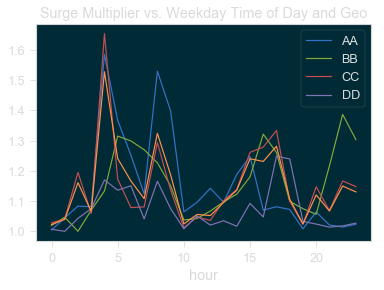

In [37]:
f = plt.figure()
ax = plt.subplot(111)
p1 = weekday_trips_geo.loc['Allen Abby'].plot(y='surge_multiplier', label="AA", ax=ax)
p2 = weekday_trips_geo.loc['Blair Bend'].plot(y='surge_multiplier', label="BB", ax=ax)
p3 = weekday_trips_geo.loc['Chelsea Court'].plot(y='surge_multiplier', label="CC", ax=ax)
p4 = weekday_trips_geo.loc['Daisy Drive'].plot(y='surge_multiplier', label="DD", ax=ax)
p5 = trips.loc[ trips.dow.isin(weekdays) ].groupby('hour').mean()['surge_multiplier'].plot(ax=ax, label="City-wide Average")
l=plt.title("Surge Multiplier vs. Weekday Time of Day and Geo")

### Time to Arrival at pick-up location

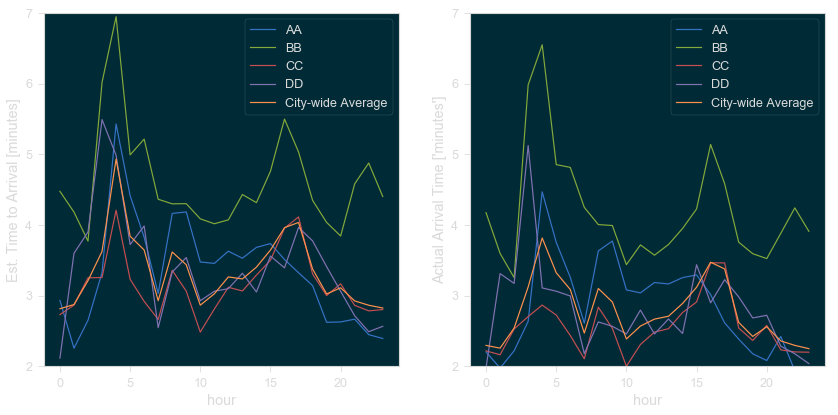

In [38]:
f = plt.figure(figsize=(14,6.5))
f1 = plt.subplot(121)
weekday_trips_geo.loc['Allen Abby']['estimated_time_to_arrival'].rename(columns={'mean':'AA'}).plot(ax=f1,label='AA')

weekday_trips_geo.loc['Blair Bend']['estimated_time_to_arrival'].rename(columns={'mean':'BB'}).plot(ax=f1, label="BB")

weekday_trips_geo.loc['Chelsea Court']['estimated_time_to_arrival'].rename(columns={'mean':'CC'}).plot(ax=f1, label="CC")
weekday_trips_geo.loc['Daisy Drive']['estimated_time_to_arrival'].rename(columns={'mean':'DD'}).plot(ax=f1, label="DD")
trips.loc[ trips.dow.isin(weekdays) ].groupby('hour').mean()['estimated_time_to_arrival'].plot(ax=f1, label="City-wide Average")
plt.legend()
plt.ylim(2,7)
plt.ylabel("Est. Time to Arrival [minutes]")

f2 = plt.subplot(122)
weekday_trips_geo.loc['Allen Abby']['actual_time_to_arrival'].rename(columns={'mean':'AA'}).plot(ax=f2, label="AA")
weekday_trips_geo.loc['Blair Bend']['actual_time_to_arrival'].rename(columns={'mean':'BB'}).plot(ax=f2, label="BB")
weekday_trips_geo.loc['Chelsea Court']['actual_time_to_arrival'].rename(columns={'mean':'CC'}).plot(ax=f2, label="CC")
weekday_trips_geo.loc['Daisy Drive']['actual_time_to_arrival'].rename(columns={'mean':'DD'}).plot(ax=f2, label="DD")
trips.loc[ trips.dow.isin(weekdays) ].groupby('hour').mean()['actual_time_to_arrival'].plot(ax=f2, label="City-wide Average")
plt.legend()
plt.ylim(2,7)
l=plt.ylabel("Actual Arrival Time ['minutes']")


### Rider cancelation rate

In [39]:
weekday_trips_geo['frac_canceled'] = (weekday_trips_geo['requests'] - weekday_trips_geo['completed'])/weekday_trips_geo['requests'] 

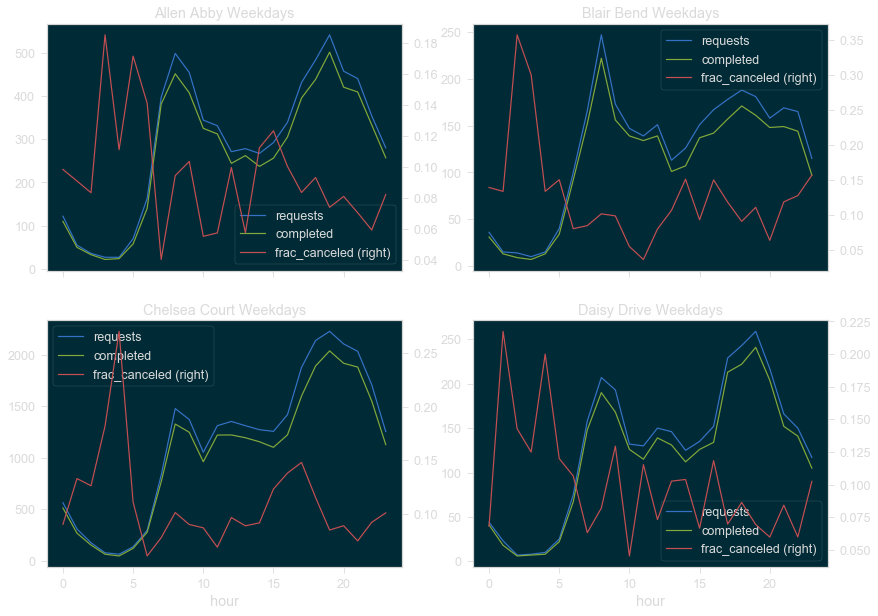

In [40]:
f = plt.figure(figsize=(14,10))
f1 = plt.subplot(221)
p = weekday_trips_geo.loc['Allen Abby'].plot(y=['requests', 'completed', 'frac_canceled'], secondary_y=['frac_canceled'], ax=f1)
plt.title("Allen Abby Weekdays")
f2 = plt.subplot(222)
p2 = weekday_trips_geo.loc['Blair Bend'].plot(y=['requests', 'completed', 'frac_canceled'], secondary_y=['frac_canceled'], ax=f2)
plt.title("Blair Bend Weekdays")
f3 = plt.subplot(223)
p3 = weekday_trips_geo.loc['Chelsea Court'].plot(y=['requests', 'completed', 'frac_canceled'], secondary_y=['frac_canceled'], ax=f3)
plt.title("Chelsea Court Weekdays")
f4 = plt.subplot(224)
p4 = weekday_trips_geo.loc['Daisy Drive'].plot(y=['requests', 'completed', 'frac_canceled'], secondary_y=['frac_canceled'], ax=f4)
l=plt.title("Daisy Drive Weekdays")


## Accuracy of the arrival time prediction



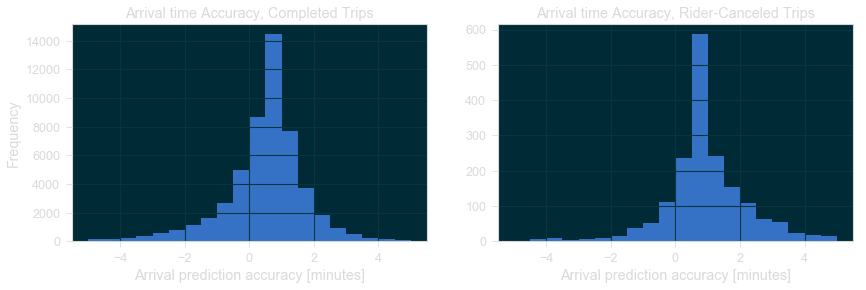

In [41]:
f = plt.figure(figsize=(14, 4))
plt.subplot(121)
trips.loc[trips['trip_status']=='completed', 'estimated_less_actual'].hist(range=(-5,5), bins=20)
plt.title("Arrival time Accuracy, Completed Trips")
plt.xlabel('Arrival prediction accuracy [minutes]')
l=plt.ylabel('Frequency')
plt.subplot(122)
trips.loc[trips['trip_status']=='rider_canceled', 'estimated_less_actual'].hist(range=(-5,5), bins=20)
plt.title("Arrival time Accuracy, Rider-Canceled Trips")
plt.xlabel('Arrival prediction accuracy [minutes]')


In [42]:
canceled_criteria = ( trips['trip_status']=='rider_canceled' ) & \
                    ~( trips['driver_id'] == '4e79-a40f')
canceled_trips = trips.loc[ canceled_criteria ]
n_canceled = len(canceled_trips)
n_cancel_with_est = canceled_trips.estimated_time_to_arrival.count()
n_cancel_with_act = canceled_trips.actual_time_to_arrival.count()
has_both = canceled_trips.loc[ ~(canceled_trips['estimated_time_to_arrival'].isnull()) & ~(canceled_trips['actual_time_to_arrival'].isnull())]
has_est_not_act = canceled_trips.loc[~(canceled_trips['estimated_time_to_arrival'].isnull()) & (canceled_trips['actual_time_to_arrival'].isnull())]
print(f"Excluding the 'super driver', there were {n_canceled} rider-canceled trips.")
print(f"   {round(100*len(has_both)/n_canceled, 1)}%, {len(has_both)} were canceled after the driver arrived to pick up.")
print(f"   {round(100*(n_canceled-n_cancel_with_est)/n_canceled,1)}%, {n_canceled - n_cancel_with_est} had no estimated arrival time.")
print(f"   {round(100*len(has_est_not_act)/n_canceled,1)}%, {len(has_est_not_act)} were canceled while driver was en-route to pick-up.")
#print( n_canceled - n_cancel_with_est, n_canceled - n_cancel_with_act)

Excluding the 'super driver', there were 5697 rider-canceled trips.
   32.1%, 1831 were canceled after the driver arrived to pick up.
   2.6%, 147 had no estimated arrival time.
   65.3%, 3719 were canceled while driver was en-route to pick-up.


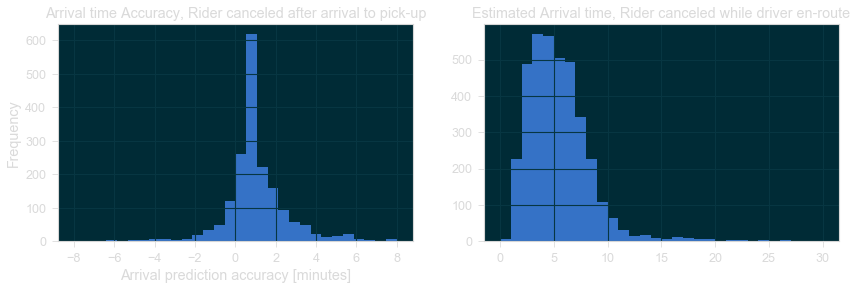

In [43]:
f = plt.figure(figsize=(14, 4))
plt.subplot(121)
has_both['estimated_less_actual'].hist(range=(-8,8), bins=30)
plt.title("Arrival time Accuracy, Rider canceled after arrival to pick-up")
plt.xlabel('Arrival prediction accuracy [minutes]')
l=plt.ylabel('Frequency')
plt.subplot(122)
has_est_not_act['estimated_time_to_arrival'].hist(range=(0,30), bins=30)
l = plt.title("Estimated Arrival time, Rider canceled while driver en-route")

In [44]:
print( "   Rider canceled after arrival for pickup:")
print(f"      Driver arrived early by {round(has_both['estimated_less_actual'].mean(),1)} minutes on average.")
print(f"      Driver arrived at least {round(has_both['estimated_less_actual'].median(),1)} minutes early for 50% of riders.")

   Rider canceled after arrival for pickup:
      Driver arrived early by 1.1 minutes on average.
      Driver arrived at least 0.9 minutes early for 50% of riders.


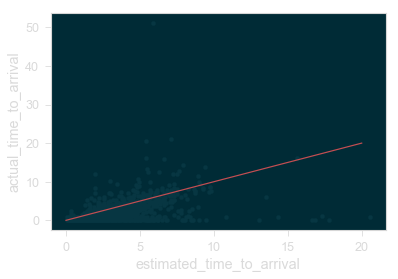

In [45]:
ax1 = has_both.plot(x='estimated_time_to_arrival', y='actual_time_to_arrival', kind='scatter', style='go')
ax2 = plt.plot([0,20], [0,20], 'r-',)

### The superhuman driver 4e79-a40f
Noticed that some of the trips don't have an estimated arrival time nor do they have actual arrival time. In the case of unfulfilled trips, or those when the rider cancels quickly after ordering, it would make sense that these values be null, but there another whole group of trips that were completed successfully that also have no arrival estimate or actual arrival times. They all correspond to the same driver_id: 4e79-a40f. 

In [46]:
drivers.loc[drivers.index == '4e79-a40f']

,first_completed_trip,lifetime_rating,lifetime_fares,lifetime_completed_trips
driver_id,,,,
4e79-a40f,10/12/2010,4.99,8.054105e+08,41940330


On the face of it, this driver has generated $805MM in fares and has performed nearly 42 million trips. 

In [47]:
n_impossible = drivers.loc[drivers.index == '4e79-a40f']['lifetime_completed_trips'].values[0]
n_years = n_impossible/12/24/365.25
print(f"This driver has a lifetime number of completed trips that, assuming just 10 minutes per trip, would take {round(n_years,0)} years to accomplish, driving non-stop, continuously booked.")

This driver has a lifetime number of completed trips that, assuming just 10 minutes per trip, would take 399.0 years to accomplish, driving non-stop, continuously booked.


In the present data set, this driver_id comprises:

<ul>
<li>2,210 completed trips
<li>80 canceled trips
<li>all 34 of the unfulfilled trips
<li>29 of the 49 failed trips.
</ul>
It is a small number of trips overall compared to the total in the dataset

In [48]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='completed') ])

2210

In [49]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='rider_canceled') ])

80

In [50]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='unfulfilled') ])

34

In [51]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='failed') ])

29

In [52]:
len(trips.loc[ ~(trips.driver_id=='4e79-a40f') & (trips.trip_status=='unfulfilled') ])

0

In [53]:
len(trips.loc[ ~(trips.driver_id=='4e79-a40f') & (trips.trip_status=='failed') ])

20

In [54]:
trips.loc[ ~(trips.driver_id=='4e79-a40f') & (trips.trip_status=='failed') ].groupby('start_geo').count()['trip_id'].rename(columns={'trip_id':'failed trips'})

start_geo
Allen Abby        2
Blair Bend        2
Chelsea Court    14
Daisy Drive       2
dtype: int64

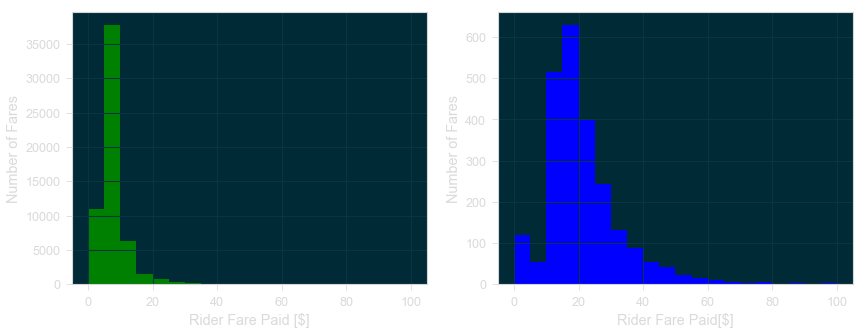

In [55]:
f = plt.figure(figsize=(14,5))
plt.subplot(121)
trips.loc[trips.driver_id != '4e79-a40f', 'rider_payment'].hist(
    range=(0,100), 
    bins=20, 
    color='green')
plt.xlabel('Rider Fare Paid [$]')
plt.ylabel('Number of Fares')
plt.subplot(122)
trips.loc[trips.driver_id == '4e79-a40f', 'rider_payment'].hist(
    range=(0,100), 
    bins=20,
    color='blue')
plt.xlabel('Rider Fare Paid[$]')
l=plt.ylabel('Number of Fares')

In [56]:
print(f"The median fare for the super driver is: ${ \
      round(trips.loc[trips.driver_id == '4e79-a40f', 'rider_payment'].median(),2)\
      }, whereas for other drivers it is ${ \
      round(trips.loc[trips.driver_id != '4e79-a40f', 'rider_payment'].median(),2) \
      }.")

The median fare for the super driver is: $18.75, whereas for other drivers it is $6.06.


Could the "Super Driver" correspond to a different service, such as Uber Black?

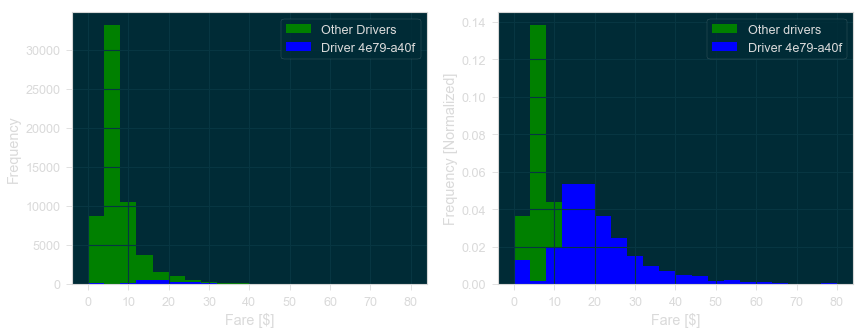

In [57]:
f = plt.figure(figsize=(14,5))
plt.subplot(121)
ax = trips['rider_payment'].hist(range=(0,80), bins=20, color='green', label="Other Drivers")
trips.loc[trips.driver_id == '4e79-a40f', 'rider_payment'].hist(range=(0,80), bins=20, color='blue', label="Driver 4e79-a40f")
plt.xlabel("Fare [$]")
plt.ylabel("Frequency")
plt.legend()
plt.subplot(122)
ax2 = trips['rider_payment'].hist(range=(0,80), bins=20, color='green', normed=True, label="Other drivers")
trips.loc[trips.driver_id == '4e79-a40f', 'rider_payment'].hist(range=(0,80), bins=20, color='blue', normed=True, label="Driver 4e79-a40f")
plt.xlabel("Fare [$]")
plt.ylabel("Frequency [Normalized]")
l = plt.legend()


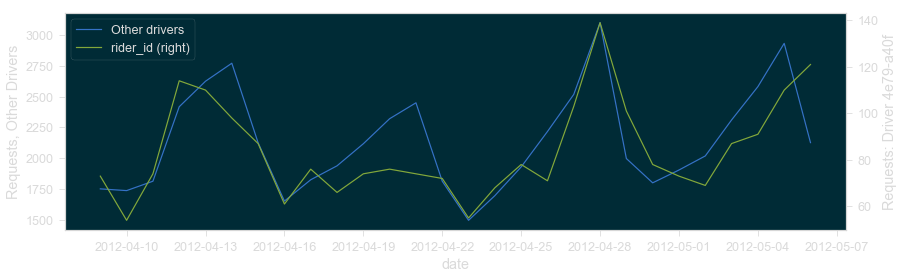

In [58]:
f = plt.figure(figsize=(14, 4))
ax = trips.groupby('date').count()['trip_id'].plot(label="Other drivers", legend=True)
plt.ylabel('Requests, Other Drivers')
trips_special = trips.loc[ trips['driver_id']=='4e79-a40f']
super_driver = trips_special.groupby('date').count()['rider_id']
pl = super_driver.plot(ax=ax, secondary_y=['rider_id'], legend=True)
l = plt.ylabel('Requests: Driver 4e79-a40f')


Trips performed by the super driver follow similar patterns in time compared to the rest. It would seem that these trips once belonged to the other driver_id's in the dataset but somehow got corrupted. No single driver could possibly do that many trips. 

Let's take note that the super driver has a lifetime rating very close to 5.0. Maybe all 5-star ratings are being recorded under this driver_id? We need access to the complete set of fields from the original database in order to do further diagnostics

## Driver trip statistics

In [59]:
completed_trips = trips.loc[trips['trip_status']=='completed']

In [60]:
completed_trips.loc[ completed_trips['estimated_time_to_arrival'].isnull(), 'driver_id' ].value_counts()

4e79-a40f    2210
Name: driver_id, dtype: int64

In [61]:
completed_trips.loc[ completed_trips['actual_time_to_arrival'].isnull(), 'driver_id' ].value_counts().sum()

2407

In [62]:
len(completed_trips.trip_id.unique())

54138

In [63]:
len(completed_trips) == len(completed_trips.trip_id.unique())

True

In [64]:
completed_trips.groupby('driver_id').count().sum()

rider_id                     54138
estimated_time_to_arrival    51928
trip_price_pre_discount      54138
rider_payment                54138
actual_time_to_arrival       51731
driver payout                54138
trip_status                  54138
request_time                 54138
surge_multiplier             54138
start_geo                    54138
end_geo                      54138
trip_id                      54138
date                         54138
dow                          54138
woy                          54138
hour                         54138
estimated_less_actual        51731
is_rush_hour                 54138
completed                    54138
canceled                     54138
requests                     54138
dtype: int64

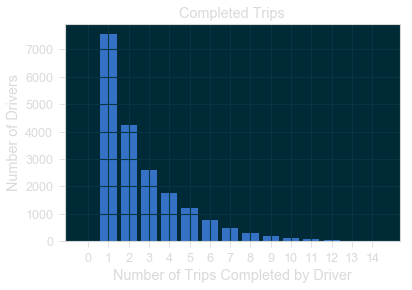

In [65]:
ax = completed_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'Completed Trips'}).hist(range=(0, 15), bins=15, width=0.8 )
plt.ylabel('Number of Drivers')
plt.xlabel('Number of Trips Completed by Driver')
ax1 = plt.xticks(np.arange(0.4, 15.4, 1), np.arange(0, 15, 1))

In [66]:
canceled_trips = trips.loc[trips['trip_status']=='rider_canceled']

In [67]:
canceled_trips.groupby('driver_id')['canceled'].count().sort_values(ascending=False).head(10)

driver_id
4e79-a40f    80
4944-de55     7
4e0b-08df     6
4c5a-bdaf     5
4f71-6965     5
432f-c925     5
4b24-2cba     4
4677-5df9     4
4606-155f     4
4706-ed8f     4
Name: canceled, dtype: int64

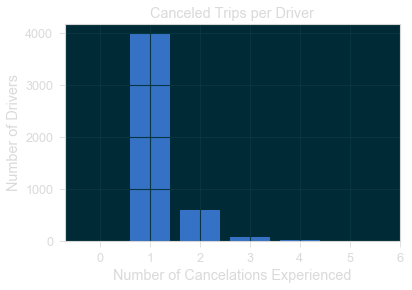

In [68]:
canceled_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'Canceled Trips per Driver'}).hist(range=(0, 6), bins=6, width=0.8)
plt.ylabel('Number of Drivers')
plt.xlabel('Number of Cancelations Experienced')
ax = plt.xticks(np.arange(0.4, 7.4, 1), np.arange(0, 7, 1))

By far, most drivers experiencing cancellations only experienced 1 cancellation. This indicates that there aren't any systemically problematic drivers causing riders to cancel. 

In [69]:
len(canceled_trips)

5777

In [70]:
local_driver_data = completed_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'completed'}).join(canceled_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'canceled'}), on='driver_id', how='inner', lsuffix='_comp', rsuffix='_canc')

In [71]:
local_driver_data['fraction_canceled'] = local_driver_data['canceled']/(local_driver_data['canceled']+ local_driver_data['completed'])

In [72]:
local_driver_data.loc[local_driver_data['completed']>20]


,completed,canceled,fraction_canceled
driver_id,,,
4e79-a40f,2210,80,0.034934


In [73]:
cancels_per_driver = trips.loc[ (trips.trip_status=='rider_canceled')].groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'canceled'})

In [74]:
completed_per_driver = trips.loc[ (trips.trip_status=='completed')].groupby('driver_id').agg({'trip_id':'count'}).rename(columns={ 'trip_id':'completed' })

In [75]:
requests_per_driver = trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'requests'})

In [76]:
driver_stats = requests_per_driver.join(cancels_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.join(completed_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.fillna(0)
driver_stats['percent_canceled'] = 100*driver_stats['canceled']/driver_stats['requests']
driver_stats = driver_stats.sort_values(['percent_canceled', 'requests'], ascending=[False, True])

In [77]:
driver_stats.completed.describe()

count    20201.000000
mean         2.679966
std         15.677789
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       2210.000000
Name: completed, dtype: float64

## Rider Cancelations

In [78]:
# First, let's look at completed trips and how frequently riders 
# experiencing a completed trip rebook
completed_trips = completed_trips.sort_values('rider_id')
completed_trips['time_between_requests'] = completed_trips.request_time.diff(-1)
completed_trips_by_rider = completed_trips.groupby('rider_id')

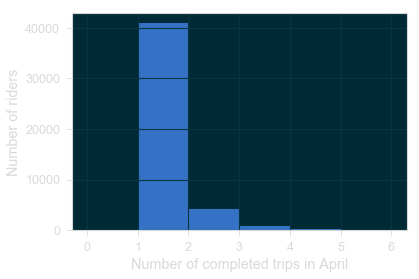

In [79]:
completed_trips_by_rider.count()['trip_id'].hist(bins=6, range=(0,6))
plt.xlabel("Number of completed trips in April")
plt.ylabel("Number of riders")

In [80]:
# If a rider orders another trip within 20 minutes and it's completed successfully, let's 
# assume the rider canceled because they either weren't ready or made a mistake. 
# However, if they don't ever request another trip, this is a big deal
rider_request_mistakes = []
rider_cancel_last_trip = []
time_to_rerequest = []

# For those riders who
time_to_next_completed_trip = []
for trip in canceled_trips.itertuples():
    window_start = trip.request_time
    window_end = trip.request_time + dt.timedelta(minutes=20)
    subsequent_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                     & (trips['request_time']>window_start) \
                                     & (trips['request_time']<window_end) \
                                     & (trips['trip_status']=='completed') ]
    if (len(subsequent_requests)>0):
        rider_request_mistakes.append(trip.Index)
        time_to_rerequest.append( subsequent_requests.request_time - trip.request_time )

    later_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                & (trips['request_time']>window_end) \
                                & (trips['trip_status']=='completed') ]
    if len(later_requests)==0:
        rider_cancel_last_trip.append(trip.Index)
    else:
        later_requests.sort_values('request_time')
        time_to_next_completed_trip.append( later_requests.iloc[0]['request_time'] \
                                          - trip.request_time )
        

            

In [81]:
fraction_rider_reorders = len(rider_request_mistakes)/len(canceled_trips)
fraction_rider_reorders

0.007616409901332871

We can see from the calculation above that less than 1% of the time that a rider cancels, s/he reorders and has a successfully completed trip within 20 minutes of the canceled trip. 

In [82]:
fraction_riders_lost = len(rider_cancel_last_trip)/len(canceled_trips)
fraction_riders_lost

0.9008135710576424

The above calculation shows that for 90% of cancelations, the rider __does not__ book another trip within the timeframe of the analysis. We should be concerned that we are at risk of losing these riders.

In [83]:
print(f"Mean time to next request: {np.mean(time_to_next_completed_trip)}")
print(f"Median time to next request: {np.median(time_to_next_completed_trip)}")
print(f"Fraction of riders canceling in this category: {round(100*len(time_to_next_completed_trip)/len(canceled_trips),2)}%")

Mean time to next request: 7 days 19:09:30.157068
Median time to next request: 6 days 03:20:00
Fraction of riders canceling in this category: 9.92%


For the remaining ~10% who do eventually book again, the average time to their next request is about 1 week. 

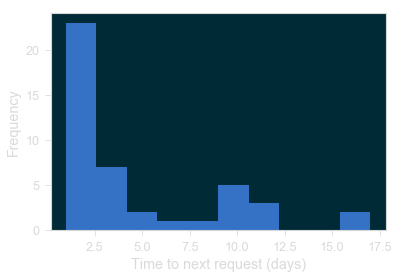

In [84]:
x, y, z = plt.hist( time_to_rerequest/np.timedelta64(60, 's') )
ax = plt.xlabel("Time to next request (days)")
ax = plt.ylabel("Frequency")

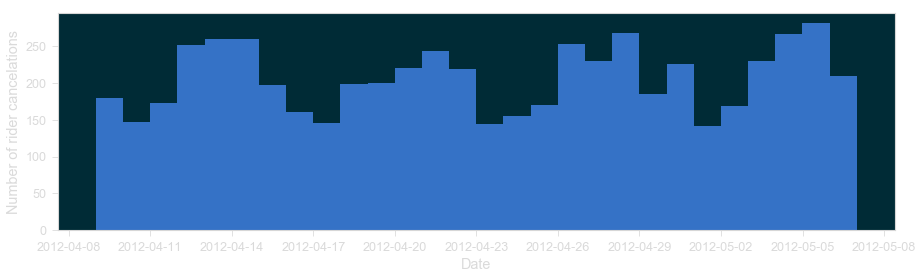

In [85]:
f = plt.figure(figsize=(15,4))
x, y, z = plt.hist(canceled_trips.request_time.values, bins=int((trips.date.max()-trips.date.min())/dt.timedelta(1)+1))
plt.xlabel("Date")
a = plt.ylabel("Number of rider cancelations")


## Statistics of completed and canceled trips

In [86]:
def norm_perc(x, n):
    return (np.round(100*len(x)/n,1), np.round((100*len(x)*np.sqrt(1/n)/n),1))

In [87]:
n_canceled_trips = len(canceled_trips)
canceled_trips.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    # 'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Canceled Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         4.63  3.19   4.07             1.21  0.39   
Blair Bend                         5.78  3.80   5.03             1.29  0.45   
Chelsea Court                      4.39  2.90   3.95             1.22  0.39   
Daisy Drive                        4.40  2.99   3.80             1.12  0.29   

                     All Canceled Trips                              
              median              count (total trips, uncertainty)%  
start_geo                                                            
Allen Abby       1.0                878                 (15.2, 0.2)  
Blair Bend       1.0                464                  (8.0, 0.1)  
Chelsea Court    1.0               4025                 (69.7, 0.9)  
Daisy Drive      1.0                410                  (7.1, 0.1)

In [88]:
completed_trips = trips.loc[trips['trip_status']=='completed']
n_completed_trips = len(completed_trips)
completed_trips.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    # 'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Completed Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         3.14  1.99   2.77             1.16  0.36   
Blair Bend                         4.24  2.48   3.87             1.20  0.36   
Chelsea Court                      3.01  1.88   2.67             1.15  0.32   
Daisy Drive                        3.18  1.99   2.77             1.10  0.25   

                     All Completed Trips                              
              median               count (total trips, uncertainty)%  
start_geo                                                             
Allen Abby       1.0                9600                 (17.7, 0.1)  
Blair Bend       1.0                3899                  (7.2, 0.0)  
Chelsea Court    1.0               36285                 (67.0, 0.3)  
Daisy Drive      1.0                4354                  (8.0, 0.0)

In [90]:
completed_trips_rush = completed_trips.loc[completed_trips['is_rush_hour']==True]
canceled_trips_rush = canceled_trips.loc[canceled_trips['is_rush_hour']==True]
n_completed_trips_rush = len(completed_trips_rush)
n_canceled_trips_rush = len(canceled_trips_rush)

In [91]:
canceled_trips_rush.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    # 'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips_rush)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Canceled Rush-hour Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         5.60  3.34   5.75             1.32  0.49   
Blair Bend                         5.77  3.80   4.92             1.28  0.41   
Chelsea Court                      5.46  3.25   4.98             1.33  0.50   
Daisy Drive                        5.00  3.35   4.60             1.16  0.29   

                     Canceled Rush-hour Trips                              
              median                    count (total trips, uncertainty)%  
start_geo                                                                  
Allen Abby       1.0                      144                 (14.0, 0.4)  
Blair Bend       1.0                       77                  (7.5, 0.2)  
Chelsea Court    1.0                      740                 (72.2, 2.3)  
Daisy Drive      1.0                       64                  (6.2, 0.2)

In [92]:
completed_trips_rush.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    # 'rider_payment':['mean'],
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips_rush)]
}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Completed Rush-hour Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         3.26  2.15   2.78             1.20  0.49   
Blair Bend                         4.35  2.35   3.98             1.21  0.32   
Chelsea Court                      3.21  1.97   2.85             1.20  0.38   
Daisy Drive                        3.35  2.13   2.93             1.19  0.32   

                     Completed Rush-hour Trips                              
              median                     count (total trips, uncertainty)%  
start_geo                                                                   
Allen Abby       1.0                      1665                 (19.1, 0.2)  
Blair Bend       1.0                       702                  (8.0, 0.1)  
Chelsea Court    1.0                      5583                 (64.0, 0.7)  
Daisy Drive      1.0                       773                  (8.9, 0.1)

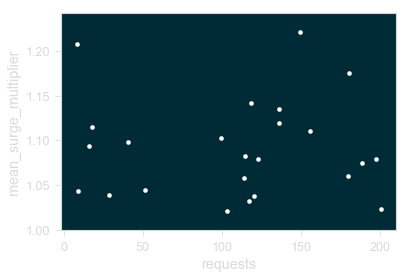

In [93]:
ax = weekday_by_hour.plot(x='requests', y='mean_surge_multiplier', kind='scatter', color='white')

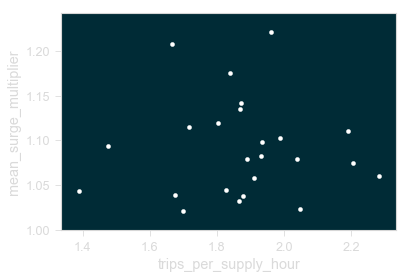

In [94]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter', color="white")

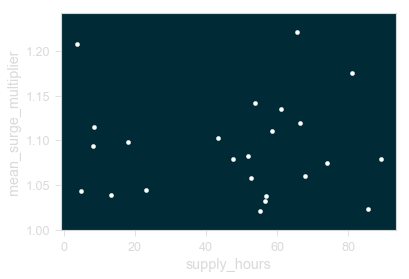

In [95]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='supply_hours', kind='scatter', color='white')

In [96]:
unfulfilled = trips.loc[ trips['trip_status'] == "unfulfilled" ]

In [97]:
start_geo_counts = trips['start_geo'].value_counts()/len(trips)
start_geo_counts

Chelsea Court    0.672706
Allen Abby       0.174889
Daisy Drive      0.079536
Blair Bend       0.072869
Name: start_geo, dtype: float64

In [98]:
unfulfilled['start_geo'].value_counts()/len(unfulfilled)

Chelsea Court    0.470588
Allen Abby       0.264706
Daisy Drive      0.147059
Blair Bend       0.117647
Name: start_geo, dtype: float64